# Lab 07: Genetic Algorithms

## Total: 50 points

In this lab, you'll explore the fundamentals of genetic algorithms by implementing core operations like selection, crossover, and mutation. We give you the initialization code and fitness function so you can focus the different ways to implement core operations.

## General Instructions

- Carefully read through the commented helper functions.
- Implement the missing functions where marked with `pass`.
- This lab is VERY open ended! There isn't one way to do this. Implement the strategies or verisons that interest you!
- **We have provided suggested parameters to pass into the unimplemented functions, but depending on the methods you pick, the parameters might change or you will need additional ones. Make sure to edit the parameter list for methods and strategies you use!!** 

In [878]:
import random
import matplotlib.pyplot as plt
import time
import numpy as np
from copy import deepcopy
from collections import Counter, defaultdict

In [861]:
# Problem Constants
NUM_PEOPLE = 5
SHIFTS_PER_DAY = 3
DAYS_PER_WEEK = 7
SHIFTS_PER_WEEK = SHIFTS_PER_DAY * DAYS_PER_WEEK # 21

In [862]:
# GA Parameters
POPULATION_SIZE = 100       # Number of schedules in each generation
GENERATIONS = 150           # Number of generations to run
MUTATION_RATE = 0.02        # Probability of a single bit flip mutation
CROSSOVER_RATE = 0.7        # Probability that crossover occurs between two parents
HARD_PENALTY = -2           # Penalty per violated hard constraint
SOFT_PENALTY = -1           # Penalty per violated soft constraint

# Helper Functions

In [863]:
## Helper Functions
def get_shift_details(shift_index):
    """
    Calculates day (0-6) and shift type (0=M, 1=A, 2=N) from shift index (0-20).

    Args:
        shift_index (int): The shift index (0-20)

    Returns:
        day (int): The day of the week (0-6)
        shift_type (int): The shift type (0=M, 1=A, 2=N)
    """
    if not (0 <= shift_index < SHIFTS_PER_WEEK):
        raise ValueError(f"shift_index {shift_index} out of range [0, {SHIFTS_PER_WEEK-1}]")
    day = shift_index // SHIFTS_PER_DAY
    shift_type = shift_index % SHIFTS_PER_DAY
    return day, shift_type

def print_schedule(schedule, fitness):
    """
    Prints the schedule in a readable format.

    Args:
        schedule (list): The schedule to print
        fitness (float): The fitness score of the schedule
    """
    print(f"\nSchedule (Fitness: {fitness:.2f}):")
    days = ["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"]
    shifts = ["M", "A", "N"]
    header = "      " + " | ".join([days[d] for d in range(DAYS_PER_WEEK)])
    # print(header)
    subheader = "      " + " ".join([f"{s}" for _ in days for s in shifts])
    # print(subheader)
    # print("      " + "-" * (len(subheader)-1))
    for person_idx, person_schedule in enumerate(schedule):
        schedule_str = ""
        for i in range(SHIFTS_PER_WEEK):
             schedule_str += str(person_schedule[i])
             if (i + 1) % SHIFTS_PER_DAY == 0 and i < SHIFTS_PER_WEEK - 1:
                 schedule_str += " " # Add space between days
        print(f"ATC {person_idx+1}: {schedule_str}")
    print("-" * (len(subheader) + 5))

def plot_fitness(fitness_history):
    """
    Plots the best and average fitness score per generation.

    Args:
        fitness_history (list): A list of fitness scores for each generation

    Returns:
        None
    """
    plt.figure(figsize=(12, 6))
    generations = range(1, len(fitness_history) + 1)
    plt.plot(generations, fitness_history, marker='o', linestyle='-', label='Best Fitness')
    plt.title('GA Fitness Progression for ATC Scheduling')
    plt.xlabel('Generation')
    plt.ylabel('Fitness Score (Higher is Better)')
    # Set y-limit to start slightly below the minimum fitness achieved or a reasonable lower bound
    min_fitness = min(fitness_history)
    plt.ylim(bottom=min(min_fitness - 5, -50)) # Adjust y-axis floor
    plt.legend()
    plt.grid(True)
    plt.show()

## Initialization

Helper code to create the initial population. Make sure you understand how we have chosen to represent the individual and population!

In [864]:
# Init GA
def generate_initial_representation(num_people, shifts_per_week):
  """
  Creates a single random schedule representation (chromosome).
  Each person gets a list of 0s and 1s for the week's shifts.

  Args:
    num_people (int): The number of people in the schedule.
    shifts_per_week (int): The number of shifts per week.

  Returns:
    schedule (list): A list of lists, where each inner list represents a person's schedule for the week.
  """
  schedule = []
  for _ in range(num_people):
    person_schedule = [random.choice([0, 1]) for _ in range(shifts_per_week)]
    schedule.append(person_schedule)
  return schedule

def generate_population(population_size, num_people, shifts_per_week):
  """ Creates the initial population of random schedules. """
  return [generate_initial_representation(num_people, shifts_per_week)
          for _ in range(population_size)]

## Fitness Function

Evaluate how close a candidate is to the target solution. Note how hard versus soft constraints are handled.

In [865]:
def evaluate_fitness(schedule, num_people, shifts_per_week, shifts_per_day):
    """ 
    Calculates the fitness of a single schedule based on constraints. 

    Args:
        schedule (list): The schedule to evaluate
        num_people (int): The number of people in the schedule
        shifts_per_week (int): The number of shifts per week
        shifts_per_day (int): The number of shifts per day

    Returns:
        fitness (float): The fitness score of the schedule
    """
    fitness = 0 # Start with perfect fitness, subtract penalties

    # Hard Constraint Checks

    # 1. Minimum controllers per shift
    min_controllers = {0: 1, 1: 2, 2: 1} # M:1, A:2, N:1
    shift_violations = 0
    for shift_idx in range(shifts_per_week):
        _, shift_type = get_shift_details(shift_idx)

        # Calculate number of controllers on this shift
        controllers_on_shift = sum(schedule[p][shift_idx] for p in range(num_people))
        required = min_controllers[shift_type]

        # Penalize for each missing controller
        if controllers_on_shift < required:
            fitness += HARD_PENALTY * (required - controllers_on_shift)
            shift_violations += (required - controllers_on_shift)

    # 2. Rest periods
    rest_violations = 0
    for p in range(num_people):
        for shift_idx in range(shifts_per_week):
            if schedule[p][shift_idx] == 1: # If person p works this shift
                _, shift_type = get_shift_details(shift_idx)

                # a) Rest after Morning (0) or Afternoon (1)
                if shift_type in [0, 1]:
                    next_shift_idx = shift_idx + 1
                    # Check boundary: ensure next shift is within the week
                    if next_shift_idx < shifts_per_week and schedule[p][next_shift_idx] == 1:
                         fitness += HARD_PENALTY # Violation: Working the very next shift
                         rest_violations += 1

                # b) Rest after Night (2)
                elif shift_type == 2:
                    # Check the next 3 shifts (full day)
                    violation_found_for_night_shift = False
                    for i in range(1, shifts_per_day + 1):
                        next_shift_idx = shift_idx + i
                        # Check boundary: ensure check stays within the week
                        if next_shift_idx < shifts_per_week and schedule[p][next_shift_idx] == 1:
                            if not violation_found_for_night_shift: # Only penalize once per night shift violation
                                fitness += HARD_PENALTY
                                rest_violations += 1
                                violation_found_for_night_shift = True
                            # No need to check further shifts for *this* night shift once violation is found

    # Soft Constraint Checks

    # 1. Excess controllers in tower
    excess_violations = 0
    for shift_idx in range(shifts_per_week):
        _, shift_type = get_shift_details(shift_idx)
        controllers_on_shift = sum(schedule[p][shift_idx] for p in range(num_people))
        required = min_controllers[shift_type]
        if controllers_on_shift > required:
            excess = controllers_on_shift - required
            fitness += SOFT_PENALTY * excess # Penalize for each extra controller
            excess_violations += excess

    # A fitness of 0 means no constraints were violated. Higher (less negative) is better.
    # You could also return the counts of violations for analysis if needed:
    # return fitness, shift_violations, rest_violations, excess_violations
    return fitness

## Q1.1 Parent Selection (4 points)

In this step, pick the parents chosen for crossover. Recall there are lots of different ways this can fit together with the crossover step. It's up to you on which method you pick.

In [866]:
def parent_selection(population, fitness_map):
    """
    Select two parents via roulette wheel selection. Parents are randomly selected with probability proportional to their fitness.

    Args:
        population (list): The current population of schedules
        fitness_map (FitnessMap): A mapping of schedules to their fitness scores
    
    Returns (tuple): A tuple of two selected parents
    """
    fitnesses = [fitness_map[schedule] for schedule in population]
    weights = [abs(min(fitnesses)) + f for f in fitnesses]
    return random.choices(population, weights=weights, k=2)

## Q1.2 Crossover (4 points)

In this step, you combine two (or more) parent chromosomes to produce an offspring (or more). Recall that you can use the CROSSOVER_RATE parameter.

In [867]:
def crossover(parent_1, parent_2, num_people, shifts_per_week, crossover_rate):
    """
    Perform multi-point crossover on two parents to create one child.
    There is a chance that no crossover occurs based on `crossover_rate`,
    in which case the returned child is just a copy of parent 1.

    Args:
        parent_1 (list): The first parent schedule
        parent_2 (list): The second parent schedule
        num_people (int): The number of people in the schedule
        shifts_per_week (int): The number of shifts per week
        crossover_rate (float): Probability of crossover occurring

    Returns (list): A child schedule created from the parents
    """
    if random.random() > crossover_rate:
        return parent_1 # No crossover, return parent 1

    crossover_points = sorted(random.sample(range(shifts_per_week), 2))
    low = crossover_points[0]
    high = crossover_points[1]
    child = []
    for i in range(num_people):
        child.append(parent_1[i][:low] + parent_2[i][low:high] + parent_1[i][high:])
    return child

## Q1.3 Mutation (4 points)

Add random mutations to chromosomes to maintain genetic diversity. You'll implement a function that randomly changes characters in the chromosome string. Recall that you can use the MUTATION_RATE parameter.

In [868]:
def mutate(schedule, mutation_rate):
    """
    Perform bit flip mutation. For each digit in the schedule,
    flip it with a probability of `mutation_rate`.

    Args:
        schedule (list): The schedule to mutate
        mutation_rate (float): Probability of mutation occurring
        num_people (int): The number of people in the schedule
        shifts_per_week (int): The number of shifts per week
    
    Returns (list): The mutated schedule
    """
    mutated_schuedule = deepcopy(schedule)
    for person in range(len(mutated_schuedule)):
        for shift in range(len(mutated_schuedule[person])):
            if random.random() < mutation_rate:
                mutated_schuedule[person][shift] = int(not mutated_schuedule[person][shift])
    return mutated_schuedule

## Q1.4 Selection (4 points)

You will implement a method for selecting parent chromosomes based on their fitness scores. The better the fitness, the higher the chance of selection.

In [869]:
import math

def select_survivors(population, offspring_population, fitness_map):
    """
    Select 10% of the best schedules from the previous generation and 90% from the offspring.

    Args:
        population (list): The current population of schedules
        offspring_population (list): The new generation of schedules
        fitness_map (FitnessMap): A mapping of schedules to their fitness scores

    Returns (list): The new population of schedules, comprised of the best from the previous generation and the new offspring
    """

    pop_size = len(population)
    best_survivors = sorted(population, key=lambda x: fitness_map[x], reverse=True)[:math.ceil(pop_size * 0.1)]
    best_offspring = sorted(offspring_population, key=lambda x: fitness_map[x], reverse=True)[:math.floor(pop_size * 0.9)]
    return best_survivors + best_offspring

## Q1.5 Putting It All Together (4 points)

Finally, integrate all components into a loop to simulate multiple generations of evolution.

In [870]:
def genetic_algorithm(population_size, num_people, shifts_per_week, shifts_per_day, days_per_week,
                      generations, mutation_rate, crossover_rate):
    """
    Run genetic algorithm to optimize ATC scheduling.

    Args:
        population_size (int): Number of schedules in each generation
        num_people (int): Number of people in the schedule
        shifts_per_week (int): Number of shifts per week
        shifts_per_day (int): Number of shifts per day
        days_per_week (int): Number of days in a week
        generations (int): Number of generations to run
        mutation_rate (float): Probability of mutation occurring
        crossover_rate (float): Probability that crossover occurs

    Returns (length 3 tuple):
        best_schedule (list): The best schedule found
        best_fitness (float): The fitness score of the best schedule
        fitness_history (list): A list of fitness scores for each generation
    """
    population = generate_population(population_size, num_people, shifts_per_week)
    fitness_history = []

    class FitnessMap:
        """
        Stores fitness scores for schedules to avoid recalculating.
        """
        def __init__(self):
            self.map = {}

        def __getitem__(self, key):
            """
            Returns the fitness score for a given schedule. Evaluates the fitness if not already calculated.

            Args:
                key (list): The schedule to evaluate
            
            Returns (float): The fitness score of the schedule
            """
            # Cast to tuple as lists are not hashable
            key = tuple(map(tuple, key))
            if key not in self.map:
                self.map[key] = evaluate_fitness(key, num_people, shifts_per_week, shifts_per_day)
            return self.map[key]

    best_schedule = None
    best_fitness = float('-inf')
    fitness_map = FitnessMap()

    for _ in range(generations):
        offspring_population = []
        # Spawn number of offspring equal to population size
        for _ in range(population_size):
            # Each cycle select new parents, crossover to form a child, and mutate the child
            parent_1, parent_2 = parent_selection(population, fitness_map)
            child = crossover(parent_1, parent_2, num_people, shifts_per_week, crossover_rate)
            child = mutate(child, mutation_rate)
            offspring_population.append(child)

        # Select survivors from past generation and current offspring
        population = select_survivors(population, offspring_population, fitness_map)
        fitnesses = [fitness_map[schedule] for schedule in population]

        # Update history
        fitness_history.append(sum(fitnesses)/len(fitnesses))

        # Check for best schedule
        if max(fitnesses) > best_fitness:
            best_fitness = max(fitnesses)
            best_schedule = deepcopy(population[np.argmax(fitnesses)])
            if best_fitness == 0:
                # Break if optimal schedule is found
                break
    return best_schedule, best_fitness, fitness_history

# Main

Run the genetic algorithm and plot the fitness scores.


      Best Schedule Found

Schedule (Fitness: 0.00):
ATC 1: 001 000 010 010 001 000 010
ATC 2: 100 010 000 100 100 010 010
ATC 3: 000 010 010 001 000 100 001
ATC 4: 010 001 000 010 010 001 000
ATC 5: 010 100 101 000 010 010 100
----------------------------------------------------


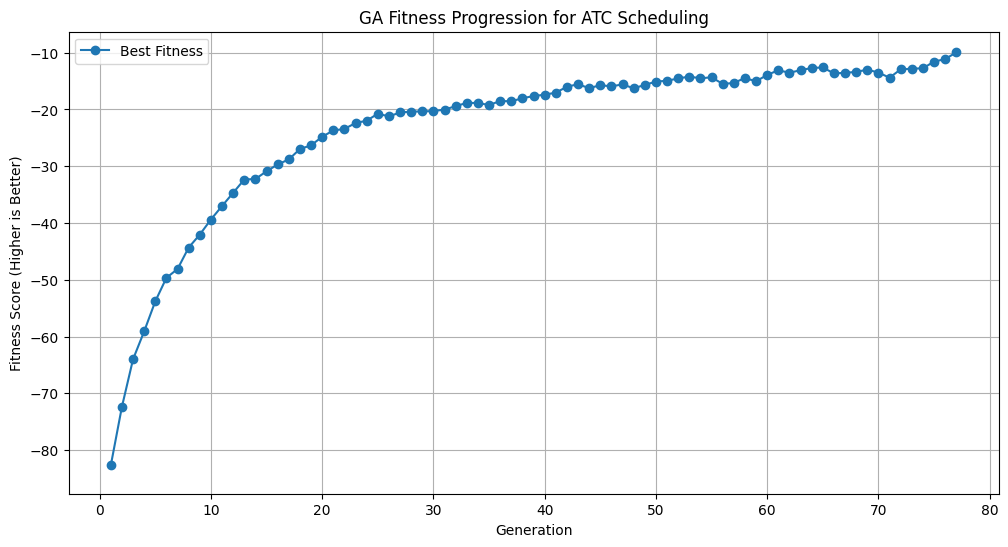

In [871]:
best_schedule, best_fitness, history = genetic_algorithm(
        population_size=POPULATION_SIZE,
        num_people=NUM_PEOPLE,
        shifts_per_week=SHIFTS_PER_WEEK,
        shifts_per_day=SHIFTS_PER_DAY,
        days_per_week=DAYS_PER_WEEK,
        generations=GENERATIONS,
        mutation_rate=MUTATION_RATE,
        crossover_rate=CROSSOVER_RATE,
    ) # CHECK THE PARAMETERS!!!

print("\n" + "="*30)
print("      Best Schedule Found")
print("="*30)
if best_schedule:
    # Evaluate the final best schedule again to be certain of its fitness score
    final_check_fitness = evaluate_fitness(best_schedule, NUM_PEOPLE, SHIFTS_PER_WEEK, SHIFTS_PER_DAY)
    print_schedule(best_schedule, final_check_fitness)
    if abs(final_check_fitness - best_fitness) > 0.01:
            print(f"[Note] Final re-evaluated fitness {final_check_fitness:.2f} differs slightly from tracked fitness {best_fitness:.2f}")
else:
    print("\nNo suitable schedule found (best_schedule is None).")
    # Explain and show the plot
    print("\n" + "="*30)
    print("      Fitness Plot Explanation")
    print("="*30)
    print("The plot shows the fitness score evolution over generations:")
    print(" - 'Best Fitness': The fitness score of the absolute best schedule found in each generation.")
    print(" - 'Average Fitness': The average fitness score of all schedules in the population for each generation.")
    print("Ideally, both lines should trend upwards (towards 0 or positive values).")
    print("The gap between average and best fitness indicates population diversity.")
plot_fitness(history)

In [877]:
# Run the GA 20 times, break if optimal schedule is found
for i in range(20):
    best_schedule, best_fitness, history = genetic_algorithm(
        population_size=POPULATION_SIZE,
        num_people=3,
        shifts_per_week=SHIFTS_PER_WEEK,
        shifts_per_day=SHIFTS_PER_DAY,
        days_per_week=DAYS_PER_WEEK,
        generations=GENERATIONS,
        mutation_rate=MUTATION_RATE,
        crossover_rate=CROSSOVER_RATE,
    )  # CHECK THE PARAMETERS!!!
    print(f"Iteration {i}, Best Fitness: {best_fitness:.2f}")
    if best_fitness == 0:
        print("===")
        print(f"optimal schedule found in {len(history)} gens")
        break

Iteration 0, Best Fitness: -12.00
Iteration 1, Best Fitness: -12.00
Iteration 2, Best Fitness: -12.00
Iteration 3, Best Fitness: -12.00
Iteration 4, Best Fitness: -12.00
Iteration 5, Best Fitness: -12.00
Iteration 6, Best Fitness: -12.00
Iteration 7, Best Fitness: -14.00
Iteration 8, Best Fitness: -12.00
Iteration 9, Best Fitness: -12.00
Iteration 10, Best Fitness: -12.00
Iteration 11, Best Fitness: -12.00
Iteration 12, Best Fitness: -12.00
Iteration 13, Best Fitness: -12.00
Iteration 14, Best Fitness: -12.00
Iteration 15, Best Fitness: -12.00
Iteration 16, Best Fitness: -12.00
Iteration 17, Best Fitness: -12.00
Iteration 18, Best Fitness: -12.00
Iteration 19, Best Fitness: -12.00


# Q2 Exploring the Solution Space (5 points)

Now that you've written a base genetic algorithm, let's see what additional information you can learn about this problem. Every air traffic controller gets paid the same amount regardless of how many shifts they work. Management wants to find the minimum number of air traffic controllers they need without creating ANY constraint violations.

a. Using your genetic algorithm solver, find the minimum number of air traffic controllers needed.

b. Describe how you came up with your answer to part A and how confident you are in that answer.

# Solution 2

a. I think you need at least 4. It may be possible with 3 but I don't think so.

b. I came up with this answer by running the block of code above and changing the number of people. With four people a solution with a fitness of 0 was found, meaning that four is possible. For three people, it wasn't able to find a solution with a fitness of 0 after 20 iterations. Additionally, almost all of the runs returned a best fitness of -12, so I'm guessing the best you can do with three people is a fitness of -12.

# Q3 Tweaking the Parameters (10 points)

Now that you've written a base genetic algorithm, let's see if you can improve the performance by tweaking the parameters. Pick one of the GA Parameters and create a plot showing the results at different values.

In [932]:
def sweep_mutation_rate(start_mut_rate, end_mut_rate, step, iterations):
    """
    Sweep through mutation rate and record number of generations needed to find optimal schedule.

    Args:
        start_mut_rate (float): The starting mutation rate
        end_mut_rate (float): The ending mutation rate
        step (float): The step size for the mutation rate sweep
        iterations (int): The number of iterations to run for each mutation rate

    Returns (dict from float to list of int): A dictionary with mutation rates as keys and
        a list of the number of generations as values
    """
    results = {}
    mut_rate = start_mut_rate
    while mut_rate <= end_mut_rate:
        print(mut_rate)
        gens = []
        for _ in range(iterations):
            best_schedule, best_fitness, history = genetic_algorithm(
                population_size=POPULATION_SIZE,  # parameter you could pick to sweep
                num_people=NUM_PEOPLE,
                shifts_per_week=SHIFTS_PER_WEEK,
                shifts_per_day=SHIFTS_PER_DAY,
                days_per_week=DAYS_PER_WEEK,
                generations=GENERATIONS,
                mutation_rate=MUTATION_RATE,  # parameter you could pick to sweep
                crossover_rate=CROSSOVER_RATE,  # parameter you could pick to sweep
            )  # CHECK THE PARAMETERS!!!
            gens.append(len(history))
        results[mut_rate] = gens
        mut_rate += step
    return results

def plot_average_gens(results, bar_width):
    """
    Plots the average number of generations to find an optimal schedule by mutation rate.

    Args:
        results (dict): A dictionary with mutation rates as keys and a list of generations as values
        bar_width (float): The width of the bars in the plot
    """
    mut_rates = list(results.keys())
    average_gens = [sum(results[mut_rate]) / len(results[mut_rate]) for mut_rate in mut_rates]
    plt.bar(mut_rates, average_gens, width=bar_width)
    plt.title('Generations to Find Optimal Schedule by Mutation Rate')
    plt.xlabel('Mutation Rate')
    plt.ylabel('Generations')
    plt.figtext(0, -0.04, "Keep in mind generations cap at 150, so for solutions that don't converge it would actually take longer")
    plt.show()


def plot_unconverged(results, iterations, bar_width):
    """
    Plots the average number of generations to find an optimal schedule by mutation rate.

    Args:
        results (dict): A dictionary with mutation rates as keys and a list of generations as values
        iterations (int): The number of iterations to run for each mutation rate, used to label the plot
        bar_width (float): The width of the bars in the plot
    """
    mut_rates = list(results.keys())
    unconverged = [results[mut_rate].count(GENERATIONS) for mut_rate in mut_rates]
    plt.bar(mut_rates, unconverged, width=bar_width)
    plt.title(f"Number of Unconverged Iterations by Mutation Rate (Over {iterations} Iterations)")
    plt.xlabel("# Unconverged Iterations")
    plt.ylabel("Generations")
    plt.show()

0
0.005
0.01
0.015
0.02
0.025
0.030000000000000002
0.035
0.04


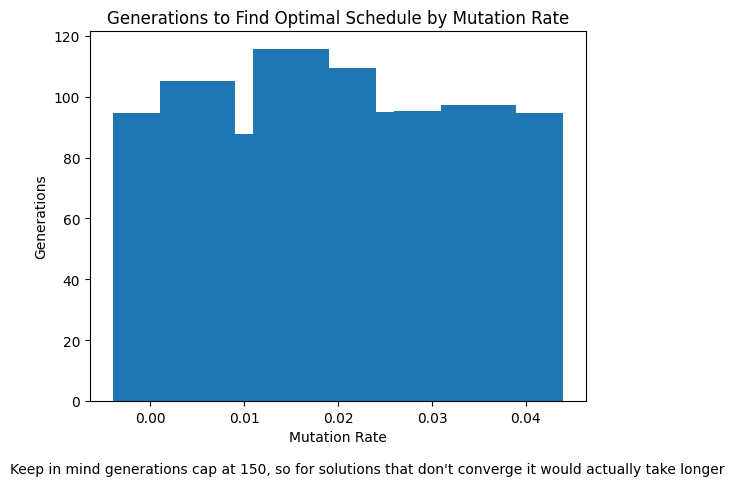

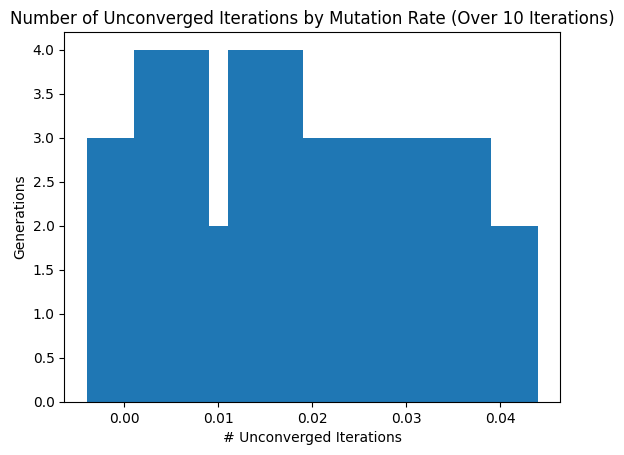

In [ ]:
# Takes about 4 mins to run
results1 = sweep_mutation_rate(0, 0.04, 0.005, 10)

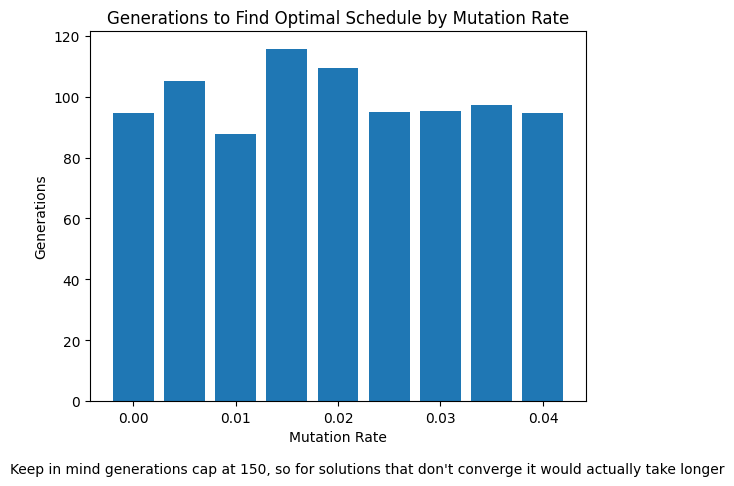

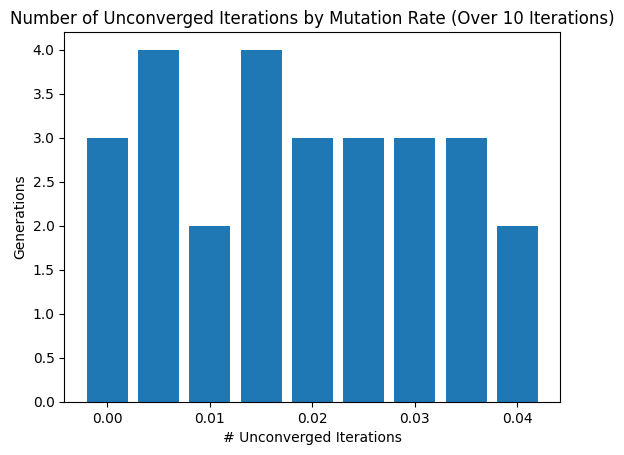

In [933]:
plot_average_gens(results1, 0.004)
plot_unconverged(results1, 10, 0.004)

In [934]:
# Takes about 4 mins to run
results2 = sweep_mutation_rate(0, 0.08, 0.01, 10)

0
0.01
0.02
0.03
0.04
0.05
0.060000000000000005
0.07
0.08


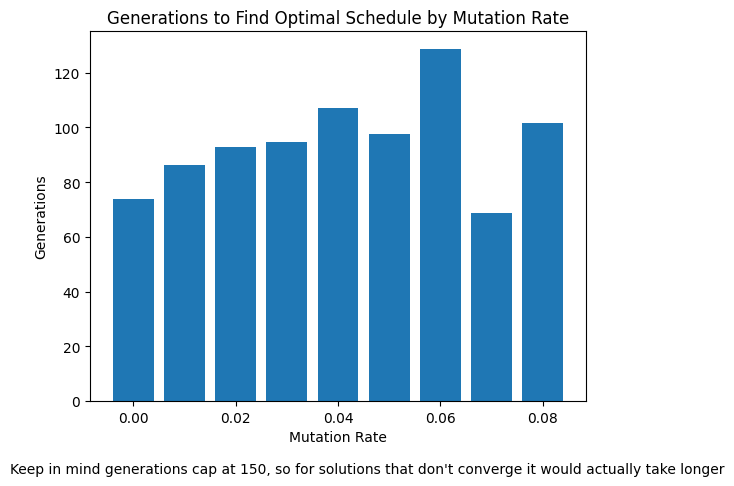

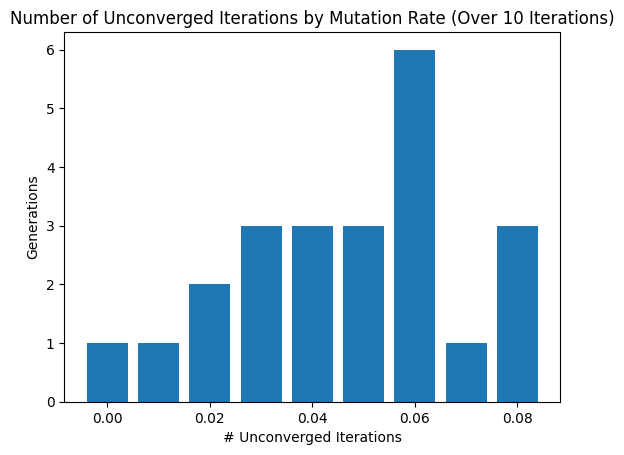

In [935]:
plot_average_gens(results2, 0.008)
plot_unconverged(results2, 10, 0.008)

### Interpret

- What parameter did you pick?

- What was optimal value for that parameter and why?

- Is there another parameter do you think that tweaking it's value will improve the results and why?

# Solution 3
- I chose to sweet through mutation rate. I was wondering how much mutation is good because too much could throw off good individuals but it could also help find the solution faster.
- I initially looked at mutation rates from 0 to 0.04, but noticed that a mutation rate of 0.04 was the best (fewest average generations to find a zero fittness solution), so I decided to try even higher mutation rates. I then tried 0 to 0.08 and saw that 0.05 did the best. I also plotted number of unconverged iterations because I was wondering if there would be a mutation rate where some of the time it converges super fast but other times it doesn't converge at all, kind of an all or nothing "strategy." This didn't appear to be the case and the graphs looked pretty similar. This all however is incredibly unscientific because I'm only averaging over 10 iterations, so tons of randomness is at play and you'll likely see different results when running the code. (I reformatted my code a bit and reran the code am getting completely different results so 💀)
- A parameter that I'm interested in tweaking isn't one of the parameters defined above, but the percentage of the past generation that carries over. I just kind of arbitrarily decided that the best 10% of the previous generation would be carried over and the other 90% is comprised of the new offspring. I'm curious if having more offspring would lead to the solution faster, or if that would cause poorly mutated offspring to throw things off.

## Q4 Changing Core Operations (15 points)

Finally, we are going to explore other methods for selection, crossover, and mutation. Choose your parent selection, mutation, crossover, or selection function and rewrite it to use a different method. Then, rerun the genetic algorithm and compare the results. Display the comparisons in a graph and interpret the results. You will do this twice; you can pick two different functions or pick the same function and come up with two different versions of it.

Completely optional, but if you are look for some inspiration this paper outlines the success of different kind of selection schemes: [A Comparative Analysis of Selection Schemes
Used in Genetic Algorithms](https://www.cse.unr.edu/~sushil/class/gas/papers/Select.pdf)

In [968]:
# Control group: average generations to convergence on existing GA
ITERATIONS = 15
gens = []
for _ in range(ITERATIONS):
    best_schedule, best_fitness, history = genetic_algorithm(
        population_size=POPULATION_SIZE,
        num_people=NUM_PEOPLE,
        shifts_per_week=SHIFTS_PER_WEEK,
        shifts_per_day=SHIFTS_PER_DAY,
        days_per_week=DAYS_PER_WEEK,
        generations=GENERATIONS,
        mutation_rate=MUTATION_RATE,
        crossover_rate=CROSSOVER_RATE,
    )  # CHECK THE PARAMETERS!!!
    gens.append(len(history))

In [969]:
control_result = sorted(gens)
control_average = sum(gens) / len(gens)

print("Generations until convergence:", control_result)
print("Average generations until convergence:", control_average)

Generations until convergence: [46, 51, 57, 69, 84, 87, 90, 112, 120, 127, 150, 150, 150, 150, 150]
Average generations until convergence: 106.2


In [988]:
def modular_GA(population_size, num_people, shifts_per_week, shifts_per_day, days_per_week,
                      generations, mutation_rate, crossover_rate, parent_selection_func=parent_selection,
                      survivor_selection_func=select_survivors):
    """
    Run genetic algorithm to optimize ATC scheduling.

    Args:
        population_size (int): Number of schedules in each generation
        num_people (int): Number of people in the schedule
        shifts_per_week (int): Number of shifts per week
        shifts_per_day (int): Number of shifts per day
        days_per_week (int): Number of days in a week
        generations (int): Number of generations to run
        mutation_rate (float): Probability of mutation occurring
        crossover_rate (float): Probability that crossover occurs

    Returns (length 3 tuple):
        best_schedule (list): The best schedule found
        best_fitness (float): The fitness score of the best schedule
        fitness_history (list): A list of fitness scores for each generation
    """
    population = generate_population(population_size, num_people, shifts_per_week)
    fitness_history = []

    class FitnessMap:
        """
        Stores fitness scores for schedules to avoid recalculating.
        """
        def __init__(self):
            self.map = {}

        def __getitem__(self, key):
            """
            Returns the fitness score for a given schedule. Evaluates the fitness if not already calculated.

            Args:
                key (list): The schedule to evaluate
            
            Returns (float): The fitness score of the schedule
            """
            # Cast to tuple as lists are not hashable
            key = tuple(map(tuple, key))
            if key not in self.map:
                self.map[key] = evaluate_fitness(key, num_people, shifts_per_week, shifts_per_day)
            return self.map[key]

    best_schedule = None
    best_fitness = float('-inf')
    fitness_map = FitnessMap()

    for _ in range(generations):
        offspring_population = []
        # Spawn number of offspring equal to population size
        for _ in range(population_size):
            # Each cycle select new parents, crossover to form a child, and mutate the child
            parent_1, parent_2 = parent_selection_func(population, fitness_map)
            child = crossover(parent_1, parent_2, num_people, shifts_per_week, crossover_rate)
            child = mutate(child, mutation_rate)
            offspring_population.append(child)

        # Select survivors from past generation and current offspring
        population = survivor_selection_func(population, offspring_population, fitness_map)
        fitnesses = [fitness_map[schedule] for schedule in population]

        # Update history
        fitness_history.append(sum(fitnesses)/len(fitnesses))

        # Check for best schedule
        if max(fitnesses) > best_fitness:
            best_fitness = max(fitnesses)
            best_schedule = deepcopy(population[np.argmax(fitnesses)])
            if best_fitness == 0:
                # Break if optimal schedule is found
                break
    return best_schedule, best_fitness, fitness_history

- Step/Method you are replacing: I am replacing the parent selection method

- Step/Method you are replacing it with: I am replcing it with pure elitism. Only the best two parents will generate all of the offspring

- Interpret the results of this replacement: From the graph below, we can see that elitism overall performed worse. For most of the iterations it didn't converge. However for the times it did converge, it did so much faster than the control. This is likely because if the initial randomized parents are good, it follows them and finds the solution quickly. However if the randomization is bad it takes too long to traverse.

In [ ]:
def elitism_parent_selection(population, fitness_map):
    """
    Select the two best parents, elitism selection.

    Args:
        population (list): The current population of schedules
        fitness_map (FitnessMap): A mapping of schedules to their fitness scores

    Returns (tuple): A tuple of two selected parents
    """
    pop_sorted = sorted(population, key=lambda x: fitness_map[x], reverse=True)
    return (pop_sorted[0], pop_sorted[1]) # Select the top two schedules

In [966]:
gens = []
for _ in range(ITERATIONS):
    best_schedule, best_fitness, history = modular_GA(
        population_size=POPULATION_SIZE,
        num_people=NUM_PEOPLE,
        shifts_per_week=SHIFTS_PER_WEEK,
        shifts_per_day=SHIFTS_PER_DAY,
        days_per_week=DAYS_PER_WEEK,
        generations=GENERATIONS,
        mutation_rate=MUTATION_RATE,
        crossover_rate=CROSSOVER_RATE,
        parent_selection_func=elitism_parent_selection,
    )  # CHECK THE PARAMETERS!!!
    gens.append(len(history))

In [967]:
elitism_result = sorted(gens)
elitism_average = sum(gens) / len(gens)

print("Generations until convergence:", elitism_result)
print("Average generations until convergence:", elitism_average)

Generations until convergence: [34, 45, 45, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150]
Average generations until convergence: 128.26666666666668


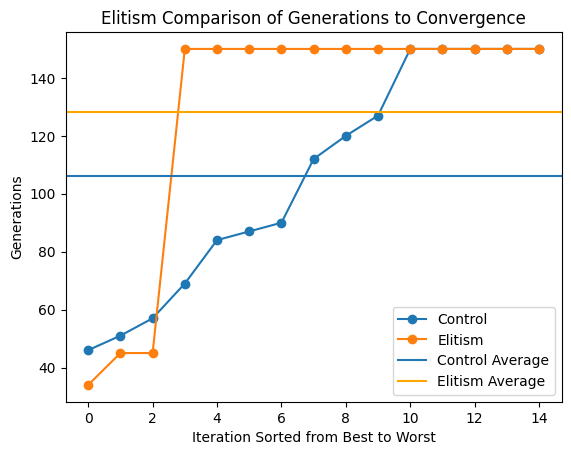

In [979]:
plt.plot(range(ITERATIONS), control_result, marker='o', linestyle='-', label='Control')
plt.plot(range(ITERATIONS), elitism_result, marker='o', linestyle='-', label='Elitism')
plt.axhline(y=control_average, label='Control Average')
plt.axhline(y=elitism_average, color="orange", label="Elitism Average")
plt.title("Elitism Comparison of Generations to Convergence")
plt.xlabel("Iteration Sorted from Best to Worst")
plt.ylabel("Generations")
plt.legend()
plt.show()

- Step/Method you are replacing: I'm replacing the survivor selection method

- Step/Method you are replacing it with: I'm replacing it with only offspring enter the new generation, no one from the previous generation.

- Interpret the results of this replacement: Only selecting offspring to survive never converged. I ran it another time to see how the best fitness changed, and it was getting better, but I'm guessing that for making the last push to fitness=0 there was too much randomness in just selecting offspring so it never made it there. It honestly makes me kind of surprised that my GA setup above worked pretty well, converging in ~100 generations.


In [981]:
def select_survivor_only_offspring(population, offspring_population, fitness_map):
    """
    Select 10% of the best schedules from the previous generation and 90% from the offspring.

    Args:
        population (list): The current population of schedules
        offspring_population (list): The new generation of schedules
        fitness_map (FitnessMap): A mapping of schedules to their fitness scores

    Returns (list): The offspring population
    """
    return offspring_population

In [989]:
gens = []
for _ in range(ITERATIONS):
    best_schedule, best_fitness, history = modular_GA(
        population_size=POPULATION_SIZE,
        num_people=NUM_PEOPLE,
        shifts_per_week=SHIFTS_PER_WEEK,
        shifts_per_day=SHIFTS_PER_DAY,
        days_per_week=DAYS_PER_WEEK,
        generations=GENERATIONS,
        mutation_rate=MUTATION_RATE,
        crossover_rate=CROSSOVER_RATE,
        survivor_selection_func=select_survivor_only_offspring,
    )  # CHECK THE PARAMETERS!!!
    gens.append(len(history))

In [985]:
only_offspring_result = sorted(gens)
only_offspring_average = sum(gens) / len(gens)

print("Generations until convergence:", only_offspring_result)
print("Average generations until convergence:", only_offspring_average)

Generations until convergence: [150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150]
Average generations until convergence: 150.0


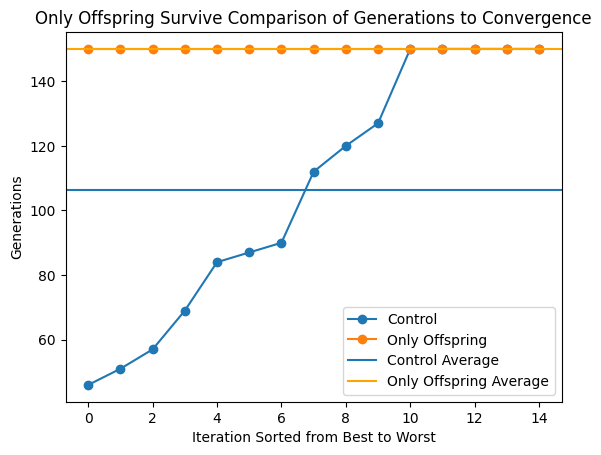

In [990]:
plt.plot(range(ITERATIONS), control_result, marker="o", linestyle="-", label="Control")
plt.plot(range(ITERATIONS), only_offspring_result, marker="o", linestyle="-", label="Only Offspring")
plt.axhline(y=control_average, label="Control Average")
plt.axhline(y=only_offspring_average, color="orange", label="Only Offspring Average")
plt.title("Only Offspring Survive Comparison of Generations to Convergence")
plt.xlabel("Iteration Sorted from Best to Worst")
plt.ylabel("Generations")
plt.legend()
plt.show()